In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
#
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

import tools
import importlib
importlib.reload(tools)

<module 'tools' from '/home/keithyamkf/jupyter-notebook/slack-trading/tools.py'>

In [21]:
import warnings

In [2]:
from sklearn.metrics import mean_squared_error

### Download data from AWS S3

In [3]:
s3_bucket = 'slack-trading'
local_path = '../data'
tools.download_data_from_s3(s3_bucket, local_path)

### CPU Count

In [4]:
cpu_count()

4

### Load the dataset

In [5]:
# dataset = pd.read_csv('../data/all_stock_close.csv')
dataset = pd.read_csv('../data/clean_10yr_stock_close.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', drop=True, inplace=True)
dataset.head(3)
#
prevday_returns = np.log(dataset.shift(1)/dataset.shift(2))
today_returns = np.log(dataset/dataset.shift(1))
#
stocks_prev = prevday_returns.columns.to_list()
stocks_today = today_returns.columns.to_list()
#
new_col = ['{}.prev'.format(c) for c in stocks_prev]
prevday_returns.columns = new_col
#
comb_df = pd.concat([prevday_returns, today_returns], axis=1)
#

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


In [6]:
# Find the NaN in comb_df
comb_df.dropna(axis=0, how='any', inplace=True)
prevday_returns = comb_df[new_col]
today_returns = comb_df[stocks_today]

In [7]:
train_prevday_returns = prevday_returns['2011-01-01':'2011-12-31']
train_today_returns = today_returns['2011-01-01':'2011-12-31']

### How R-Squared is impacted by number of independent variabkles

In [8]:
# result_df = pd.read_csv('../data/regression_pair.csv', index_col=0)
result_df = pd.read_csv('../data/10yr_regression_pair.csv', index_col=0)
sorted_df = result_df.sort_values(by='RSquared', ascending=False)
sorted_df.head(10)

,Prev,Today,Params,TValues,RSquared
106223,0266.HK.prev,0952.HK,2.637893,12.012917,0.374530
79435,0202.HK.prev,2323.HK,0.319674,10.792716,0.325842
504446,6823.HK.prev,0720.HK,-0.164456,10.635044,0.319409
146711,0373.HK.prev,1003.HK,1.269368,10.366868,0.308409
94429,0237.HK.prev,6823.HK,4.017138,8.961810,0.249955
100645,0252.HK.prev,1223.HK,0.355493,8.581045,0.234031
100294,0252.HK.prev,0335.HK,0.531830,7.466439,0.187862
110674,0273.HK.prev,2319.HK,0.088088,7.230479,0.178259
51850,0128.HK.prev,0026.HK,0.084212,7.148107,0.174927
110307,0273.HK.prev,0526.HK,-0.140535,6.826599,0.162038


In [9]:
filtered_df = result_df[result_df['Today']=='0952.HK'].sort_values(by='RSquared', ascending=False)

In [10]:
dep_variable = '0952.HK'
indp_rsq_ls = list()
for i in range(1,200):
    indp_variables = filtered_df['Prev'].to_list()[:i]
    X = train_prevday_returns[indp_variables].copy()
    X = sm.add_constant(X)
    y = train_today_returns[dep_variable]
    model = sm.OLS(y, X).fit()
    #
    outcome_dict = {
        'no_var' : i,
        'rsquared' : model.rsquared
    }
    indp_rsq_ls.append(outcome_dict)
    #

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [11]:
indp_rsq_df = pd.DataFrame(indp_rsq_ls)
indp_rsq_df[:5]

,no_var,rsquared
0,1,0.374530
1,2,0.392850
2,3,0.401575
3,4,0.415010
4,5,0.429877


In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
def plot_two_stocks(dep_variable, x, y):
    fig, ax = plt.subplots()  # Create a figure containing a single axes.
    ax.set_xlabel('Number of independent variables')
    ax.set_ylabel('R Squared')
    ax.set_title('Dependent Variable : {}'.format(dep_variable))
    ax.plot(x, y)  # Plot some data on the axes.

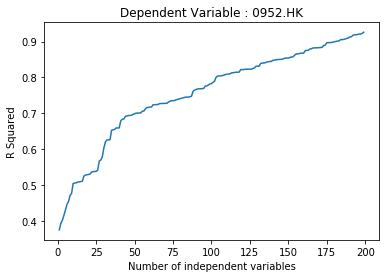

In [13]:
plot_two_stocks(dep_variable, indp_rsq_df['no_var'], indp_rsq_df['rsquared'])

### Conclusion : The more the independent variables, the better the R Squared score

### How to create different sets of independent variables

In [14]:
filtered_df[:5]

,Prev,Today,Params,TValues,RSquared
106223,0266.HK.prev,0952.HK,2.637893,12.012917,0.374530
79243,0202.HK.prev,0952.HK,0.223215,4.936241,0.091822
92023,0230.HK.prev,0952.HK,0.486560,4.636106,0.081882
444894,2323.HK.prev,0952.HK,0.368802,4.534547,0.078613
341234,1085.HK.prev,0952.HK,0.354436,4.278952,0.070608


### Train and Test - Regression Error

In [15]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [16]:
depd_stock = "0952.HK"
indepd_set = [4, 50]

In [22]:
warnings.filterwarnings("ignore")

In [24]:
for num_indepd in indepd_set:
    indepd_stock = filtered_df['Prev'].to_list()[:num_indepd]
    #
    train_start_txt = '2011-01-01'
    train_end_txt = '2011-12-31'
    train_start = datetime.strptime(train_start_txt, '%Y-%m-%d')
    train_end = datetime.strptime(train_end_txt, '%Y-%m-%d')
    test_start = train_end + relativedelta(days=1)
    test_end = train_end + relativedelta(months=3)
    #
    result_ls = list()
    for i in range(0, 10):
        train_prevday_returns = prevday_returns[train_start:train_end]
        train_today_returns = today_returns[train_start:train_end]
        test_prevday_returns = prevday_returns[test_start:test_end]
        test_today_returns = today_returns[test_start:test_end]
        #
        X_train = train_prevday_returns[indepd_stock].copy()
        X_train = sm.add_constant(X_train)
        y_train = train_today_returns[depd_stock]
        model = sm.OLS(y_train, X_train).fit()
        #
        y_train_pred = model.predict(X_train)
        train_mse = mean_squared_error(y_train, y_train_pred)
        #
        X_test = test_prevday_returns[indepd_stock].copy()
        X_test = sm.add_constant(X_test)
        y_test = test_today_returns[depd_stock]
        y_test_pred = model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_test_pred)
        #
        result = {
            'in start' : train_start,
            'in end' : train_end,
            'out start' : test_start,
            'out end' : test_end,
            'in mse' : train_mse,
            'out mse' : test_mse,
            'in mse to out mse ratio' : train_mse / test_mse
        }
        result_ls.append(result)
        #
        train_start = train_start + relativedelta(months=3)
        train_end = train_end + relativedelta(months=3)
        test_start = test_start + relativedelta(months=3)
        test_end = test_end + relativedelta(months=3)
    print('{} independent variables'.format(len(indepd_stock)))
    result_df = pd.DataFrame(result_ls)
    with pd.option_context('expand_frame_repr', False):
        print(result_df)
        print(result_df.describe())

4 independent variables
    in start     in end  out start    out end    in mse   out mse  in mse to out mse ratio
0 2011-01-01 2011-12-31 2012-01-01 2012-03-31  0.001827  0.001061                 1.721100
1 2011-04-01 2012-03-31 2012-04-01 2012-06-30  0.001739  0.001331                 1.306581
2 2011-07-01 2012-06-30 2012-07-01 2012-09-30  0.001653  0.002331                 0.708933
3 2011-10-01 2012-09-30 2012-10-01 2012-12-30  0.001706  0.001395                 1.222815
4 2012-01-01 2012-12-30 2013-01-01 2013-03-30  0.000988  0.000856                 1.155012
5 2012-04-01 2013-03-30 2013-04-01 2013-06-30  0.000975  0.001581                 0.616926
6 2012-07-01 2013-06-30 2013-07-01 2013-09-30  0.001051  0.001305                 0.805504
7 2012-10-01 2013-09-30 2013-10-01 2013-12-30  0.001057  0.002190                 0.482414
8 2013-01-01 2013-12-30 2014-01-01 2014-03-30  0.001424  0.001294                 1.100188
9 2013-04-01 2014-03-30 2014-04-01 2014-06-30  0.001544  0.000910 

### Experiment Training

In [ ]:
depd_stock = "0952.HK"
indepd_stock = indp_variables
train_start = '2011-01-01'
train_end = '2011-12-31'
train_prevday_returns = prevday_returns[train_start:train_end]
train_today_returns = today_returns[train_start:train_end]

In [ ]:
X = train_prevday_returns[indepd_stock].copy()
X = sm.add_constant(X)
y = train_today_returns[depd_stock]
model = sm.OLS(y, X).fit()
print('Params {:.4f} TValues {:.4f} RSquared {:.4f}'.format(model.params.iloc[1], model.tvalues.iloc[1], model.rsquared))

In [ ]:
model.summary()

In [ ]:
train_predicted = model.predict(X)
train_predicted

In [ ]:
y.head(10)

In [ ]:
mean_squared_error(y, train_predicted)

In [ ]:
test_start = '2012-01-01'
test_end = '2012-03-31'
test_prevday_returns = prevday_returns[test_start:test_end]
test_today_returns = today_returns[test_start:test_end]

In [ ]:
X_test = test_prevday_returns[indepd_stock].copy()
X_test = sm.add_constant(X_test)
y_test = test_today_returns[depd_stock]

In [ ]:
test_predicted = model.predict(X_test)
test_predicted

In [ ]:
mean_squared_error(y_test, test_predicted)